<a href="https://colab.research.google.com/github/johnkevinoregan/Learning-Relations-with-Deep-Learning/blob/main/Brightness_judgement_on_1D_retina.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Brightness judgement on 1D retina
##Functions used to Create Training Examples with holes which are not trained

In [105]:
#K Generate training samples for Brightness judgement
#PixToSkip is the number of retinal pixels inbetween two successive retinal locations where there can be a training sample. You can use the value 0 if you dont want to skip locations.
#LeftNumToTrain is the number of retinal locations on the left side of the retina you want to train
#NumInHole is the number of those retinal locations in the center of the retina where you choose not to train (in order to test generalization)
#RightNumToTrain is the number of retinal locations on the right side of the retina you want to train
#As an example : generate_training_set(0,4,0,4) generates a training set with a retina of size 8 where all locations will be trained (+'s) and there is no hole: ++++++++ 
#generate_training_set(0,4,3,4) does the same except now there is a hole where there is no training (.'s): ++++...++++ (the retina is now of length 11)
#generate_training_set(1,4,3,4) does the same again, except now there are also skipped pixels inbetween all the training locations: +.+.+.+......+.+.+.+

#For this brightness task, each retinal locations gets 1 example with high brightness, and 1 with low brightness. 
#At each retinal location, the array X_locs_trained[] is updated by 0.5 for each brightness, so should equal 1 if the arrays are properly filled.

def generate_bright_training_set(Brightnesses,PixToSkip,LeftNumToTrain,NumInHole,RightNumToTrain): 
  TotNumToTrain=LeftNumToTrain+RightNumToTrain
  LastRetinaPixel=(TotNumToTrain+NumInHole-1)*(PixToSkip+1)
  Midpoint=LastRetinaPixel/2
  #print(Midpoint)
  X_trials=[[0 for col in range(LastRetinaPixel+1)] for row in range(2*TotNumToTrain)]
  X_locs_trained=[0 for col in range(LastRetinaPixel+1)]
  StepInterval=PixToSkip+1
  i=0
  for b in range(0,2):
    #print('b', b)
    for j in range(LeftNumToTrain):
      RetPos=j*StepInterval
      #print(i,RetPos)
      X_trials[i][RetPos]=Brightnesses[b]
      X_locs_trained[RetPos]+=0.5
      #print(X_trials[i])
      i+=1
      #print('left')
    for j in range(RightNumToTrain):
      RetPos=(LeftNumToTrain+NumInHole+j)*StepInterval
      #print(i,RetPos)
      X_trials[i][RetPos]=Brightnesses[b]
      X_locs_trained[RetPos]+=0.5
      #print(X_trials[i])
      i+=1
      #print('right')

  return(X_trials,X_locs_trained)

#K This function generates a list of all the possible tests for brightness judgements
#you give it the same parameters as for the training set so it can calculate how long the retina is
def generate_bright_test_set(Brightnesses,PixToSkip,LeftNumToTrain,NumInHole,RightNumToTrain):
  TotNumToTrain=LeftNumToTrain+RightNumToTrain
  RetinaSize=(TotNumToTrain+NumInHole-1)*(PixToSkip+1)+1
  AllPossTests=[[0 for row in range(RetinaSize)] for col in range(2*RetinaSize)]
  for b in range(0,2):
    #print('b',b)
    for i in range(RetinaSize):
      AllPossTests[i+b*RetinaSize][i]=Brightnesses[b]
  return(AllPossTests)

# K generate labels based on the index of 1 in each row of the Training or Test set
def generate_bright_labels(Brightnesses,Set):
  Labels=[0 if max(row)==Brightnesses[0] else 1 for row in Set]
  return Labels


##Make data sets X_train and labels y_train, and testing sets X_test and labels y_test

In [ ]:
Brightnesses=[50,200]
X_train,X_locs_trained=generate_bright_training_set(Brightnesses,0,10,10,10)
#np.random.shuffle(X_train)
y_train=generate_bright_labels(Brightnesses,X_train)
print('locations trained')
print(X_locs_trained)
print()

print('training set')
for i in range(len(X_train)):
  print(X_train[i], 'label',y_train[i])
print()

X_test=generate_bright_test_set(Brightnesses,0,10,10,10)
y_test=generate_bright_labels(Brightnesses,X_test)
#print('test set')
for i in range(len(X_test)):
  print(X_test[i], 'label',y_test[i])
print()



## Either: Train with normal NN

In [ ]:
# Build, compile and train the neural network model
#there are two hidden layers with 64 and 32 values
#The ReLU activation function is used in deep learning models to introduce non-linearity into the network
#the sigmoid activation function produces a probability value between 0 and 1
from tensorflow import keras
import numpy as np
#from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten
#from sklearn.model_selection import train_test_split


model = keras.models.Sequential([
    keras.layers.Dense(64, activation="relu", input_dim=len(X_train[0])),
    keras.layers.Dense(32, activation="relu"),
    keras.layers.Dense(1, activation="sigmoid")
])

# Compile the model
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

#Don't run this
# Split the data into training and testing sets
#X_train, X_test, y_train, y_test = train_test_split(df, labels, test_size=0.2, random_state=42)

# Train the model
model.fit(X_train, y_train, epochs=160, batch_size=32, validation_data=(X_test, y_test))



###Test normal NN on all retinal positions

In [ ]:
#Test on all retinal positions including non-trained ones
# NB the logic is different compared to the Left/Right judgement task!!
# We plot separately the predictions for the two brightness levels at each RetPos
NumTrials=len(X_test)
RetinaSize=len(X_test[0])
results=[[0 for row in range(0,2)] for col in range(RetinaSize)]
for trial in range(NumTrials):
  pred=model.predict(np.array([X_test[trial]]))
  estimate=pred[0][0]
  bright=max(X_test[trial])
  which=Brightnesses.index(bright)
  RetPos=X_test[trial].index(bright)
  print(which,RetPos,estimate)
  results[RetPos][which]=estimate
print(results)

###Plot Result for normal NN

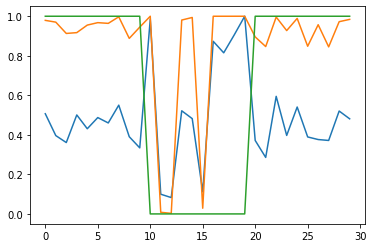

In [108]:
#import numpy as np
#arr = np.array(results)
#print(np.round(arr, decimals=2))

import matplotlib.pyplot as plt
plt.plot(results)
plt.plot(X_locs_trained)

## Or: Train with CNN

In [ ]:
model = Sequential()
model.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(len(X_train[0]), 1)))
model.add(MaxPooling1D(pool_size=2))
#model.add(Conv1D(filters=64, kernel_size=5, activation='relu'))
#model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=80, batch_size=32, verbose=1)

#loss, accuracy = model.evaluate(X_test, y_test, verbose=1)
#print("Accuracy:", accuracy)

###Test CNN on all retinal positions

In [ ]:
#Test on all retinal positions including non-trained ones
# NB the logic is different compared to the Left/Right judgement task!!
# We plot separately the predictions for the two brightness levels at each RetPos
NumTrials=len(X_test)
RetinaSize=len(X_test[0])
results=[[0 for row in range(0,2)] for col in range(RetinaSize)]
for trial in range(NumTrials):
  pred=model.predict(np.array([X_test[trial]]))
  estimate=pred[0][0]
  bright=max(X_test[trial])
  which=Brightnesses.index(bright)
  RetPos=X_test[trial].index(bright)
  print(which,RetPos,estimate)
  results[RetPos][which]=estimate
print(results)

###Plot result for CNN

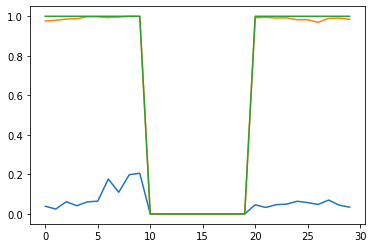

In [111]:
#import numpy as np
#arr = np.array(results)
#print(np.round(arr, decimals=2))

import matplotlib.pyplot as plt
plt.plot(results)
plt.plot(X_locs_trained)
